In [72]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [41]:
# Répertoires de données
train_dir = '/content/train'
test_dir = '/content/test'

# Générateurs de données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Réduire la taille des images à 128x128 pour un entraînement plus rapide
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    #shuffle=False  # Important pour avoir les mêmes images à chaque appel
)

Found 224 images belonging to 3 classes.
Found 189 images belonging to 3 classes.


In [8]:
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16, MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Fonction pour construire un modèle avec une architecture de base donnée
def build_model(base_model_class, input_shape=(128, 128, 3), num_classes=1):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Liste des modèles à évaluer
model_classes = [ResNet50, InceptionV3, VGG16, MobileNetV2, EfficientNetB0]
model_names = ['ResNet50', 'InceptionV3', 'VGG16', 'MobileNetV2', 'EfficientNetB0']
models = []

for model_class in model_classes:
    model = build_model(model_class)
    models.append(model)

# Entraînement des modèles
history_list = []
for model, model_name in zip(models, model_names):
    print(f"Training {model_name}...")
    history = model.fit(
        train_generator,
        epochs=5,  # Réduire le nombre d'époques pour un entraînement plus rapide
        validation_data=test_generator,
        verbose=2
    )
    history_list.append((model_name, history))

Training ResNet50...
Epoch 1/5
7/7 - 37s - 5s/step - accuracy: 0.4911 - loss: -2.2447e+00 - val_accuracy: 0.4921 - val_loss: -5.1635e+00
Epoch 2/5
7/7 - 37s - 5s/step - accuracy: 0.5000 - loss: -7.0277e+00 - val_accuracy: 0.4921 - val_loss: -1.0160e+01
Epoch 3/5
7/7 - 42s - 6s/step - accuracy: 0.5000 - loss: -1.2140e+01 - val_accuracy: 0.4921 - val_loss: -1.6076e+01
Epoch 4/5
7/7 - 35s - 5s/step - accuracy: 0.5000 - loss: -1.8525e+01 - val_accuracy: 0.4921 - val_loss: -2.3465e+01
Epoch 5/5
7/7 - 31s - 4s/step - accuracy: 0.5000 - loss: -2.6604e+01 - val_accuracy: 0.4921 - val_loss: -3.2613e+01
Training InceptionV3...
Epoch 1/5
7/7 - 26s - 4s/step - accuracy: 0.4330 - loss: -7.0698e+01 - val_accuracy: 0.4921 - val_loss: -1.6925e+02
Epoch 2/5
7/7 - 15s - 2s/step - accuracy: 0.5000 - loss: -2.5317e+02 - val_accuracy: 0.4921 - val_loss: -3.9208e+02
Epoch 3/5
7/7 - 15s - 2s/step - accuracy: 0.5000 - loss: -5.1120e+02 - val_accuracy: 0.4921 - val_loss: -6.8658e+02
Epoch 4/5
7/7 - 14s - 2s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


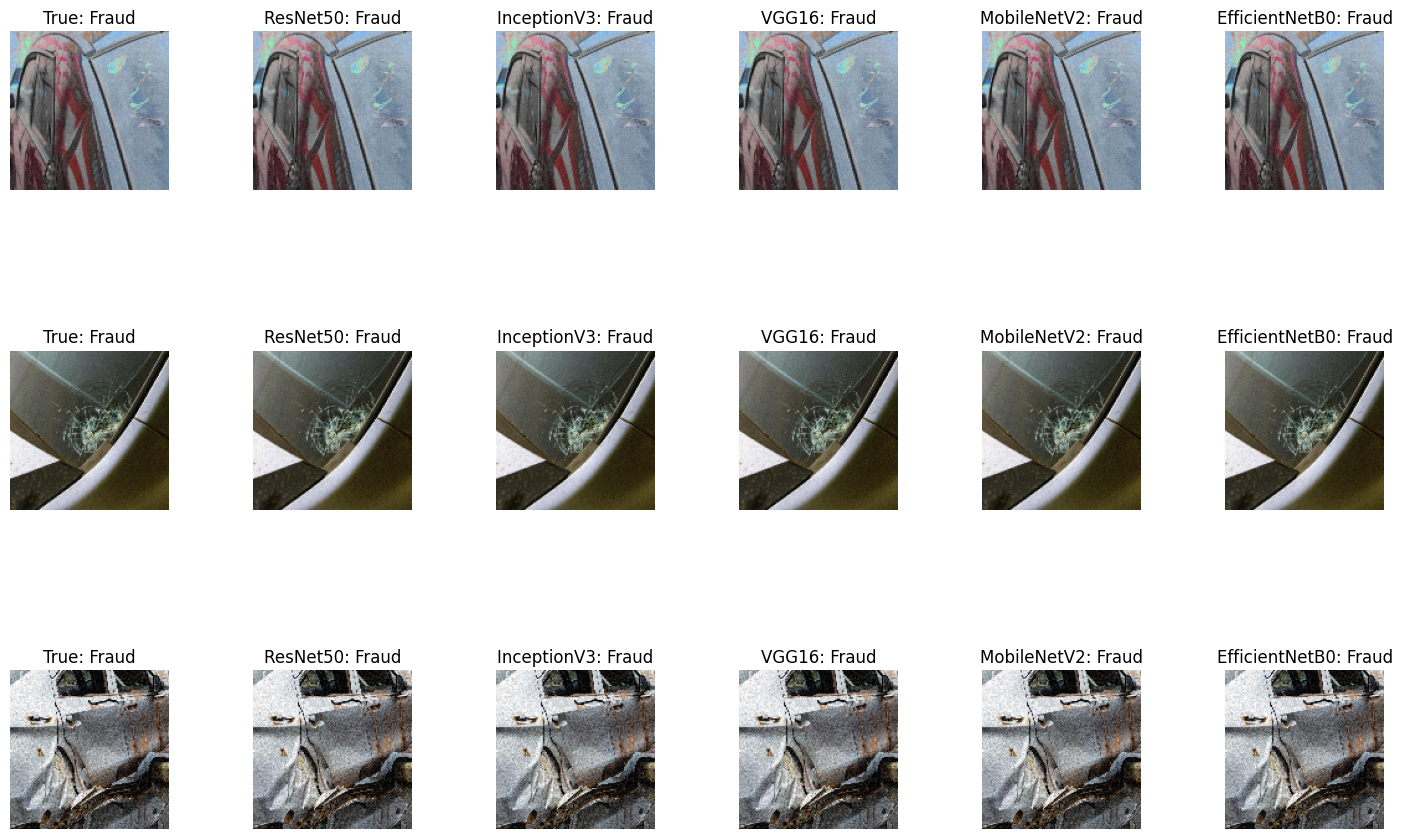

In [101]:
# Fonction pour afficher des images avec leurs étiquettes réelles et prédites
def plot_predictions(images, true_labels, predictions, model_names):
    fig, axes = plt.subplots(len(images), len(model_names) + 1, figsize=(15, 10))
    fig.tight_layout(pad=3.0)

    for i, img in enumerate(images):
        # Afficher l'image et la véritable étiquette dans la première colonne
        ax = axes[i, 0]
        ax.imshow(img)
        ax.set_title(f"True: {'Fraud' if true_labels[i] else 'Non-Fraud'}")
        ax.axis('off')

        # Afficher les prédictions de chaque modèle dans les colonnes suivantes
        for j, (prediction, model_name) in enumerate(zip(predictions, model_names)):
            ax = axes[i, j + 1]
            ax.imshow(img)
            pred_label = 'Fraud' if prediction[i] else 'Non-Fraud'
            ax.set_title(f"{model_name}: {pred_label}")
            ax.axis('off')
    plt.show()

# Charger quelques images de l'ensemble de test
num_images = 3
test_images, test_labels = [], []

# Collecter un certain nombre d'images et d'étiquettes
for _ in range(num_images):
    img_batch, label_batch = next(test_generator)
    test_images.extend(img_batch)
    test_labels.extend(label_batch)

test_images = np.array(test_images[:num_images])
test_labels = np.array(test_labels[:num_images])

# Faire des prédictions avec chaque modèle
predictions = []
metrics = []
for model, model_name in zip(models, model_names):
    y_pred = model.predict(test_images, verbose=1)
    y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
    predictions.append(y_pred_classes)

    # Calculer les métriques
    accuracy = np.mean(y_pred_classes == test_labels)
    precision = precision_score(test_labels, y_pred_classes)
    recall = recall_score(test_labels, y_pred_classes)
    f1 = f1_score(test_labels, y_pred_classes)

    metrics.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Afficher les prédictions
plot_predictions(test_images, test_labels, predictions, model_names)

In [102]:
metrics_df = pd.DataFrame(metrics)
metrics_df


,Model,Accuracy,Precision,Recall,F1-Score
0,ResNet50,0.666667,0.666667,1.0,0.8
1,InceptionV3,0.666667,0.666667,1.0,0.8
2,VGG16,0.666667,0.666667,1.0,0.8
3,MobileNetV2,0.666667,0.666667,1.0,0.8
4,EfficientNetB0,0.666667,0.666667,1.0,0.8
